# Đề thi mẫu chứng chỉ TensorFlow - Dạng bài 05

```
ProtonX - TensorFlow Class
```
Giới thiệu về chứng chỉ - https://www.tensorflow.org/certificate

> Chú ý: đọc kỹ các nội dung trong Handle Notebook trong liên kết trên.

---

### Hướng dẫn làm bài

Một số yêu cầu:
- Sử dụng TensorFlow.

Tiêu chí chấm điểm:
- Yêu cầu MAE < 0.12




### Thực hiện

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv \
    -O /tmp/sunspots.csv

--2023-10-11 00:18:28--  https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/plain]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.002s  

2023-10-11 00:18:28 (27.3 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



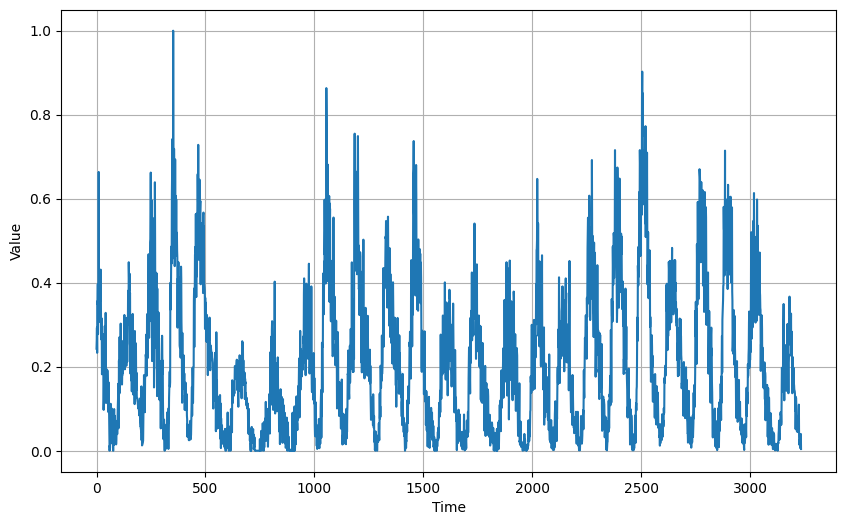

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [ ]:


lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

history = model.fit(
    train_set,
    validation_data=(test_set),
    epochs=100,
    callbacks=[lr_schedule])

Epoch 1/100
77/77 [==============================] - 17s 63ms/step - loss: 0.0299 - mae: 0.1878 - val_loss: 0.0379 - val_mae: 0.2185 - lr: 1.0000e-08
Epoch 2/100
77/77 [==============================] - 3s 30ms/step - loss: 0.0299 - mae: 0.1878 - val_loss: 0.0379 - val_mae: 0.2184 - lr: 1.1220e-08
Epoch 3/100
77/77 [==============================] - 3s 40ms/step - loss: 0.0299 - mae: 0.1878 - val_loss: 0.0379 - val_mae: 0.2184 - lr: 1.2589e-08
Epoch 4/100
77/77 [==============================] - 2s 19ms/step - loss: 0.0299 - mae: 0.1877 - val_loss: 0.0379 - val_mae: 0.2183 - lr: 1.4125e-08
Epoch 5/100
77/77 [==============================] - 2s 18ms/step - loss: 0.0299 - mae: 0.1877 - val_loss: 0.0379 - val_mae: 0.2183 - lr: 1.5849e-08
Epoch 6/100
77/77 [==============================] - 2s 18ms/step - loss: 0.0299 - mae: 0.1876 - val_loss: 0.0379 - val_mae: 0.2182 - lr: 1.7783e-08
Epoch 7/100
77/77 [==============================] - 2s 19ms/step - loss: 0.0299 - mae: 0.1876 - val_loss

In [ ]:
# Lưu Model và nộp
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast
model.save("sunspots_mymodel.h5")

100/100 [==============================] - 2s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
